# 作業 : (Kaggle)房價預測

# [作業目標]
- 試著模仿範例寫法, 在房價預測中, 觀察去除離群值的影響

# [作業重點]
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[6], Out[6])

In [6]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import copy

data_path = 'data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df_train['SalePrice'])
df = df_train.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [8]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?
* 答：<font color="red">嘗試以250､2500做為下限、上限後，驗證分數從原本的0.8499略微提升到0.8887</font>

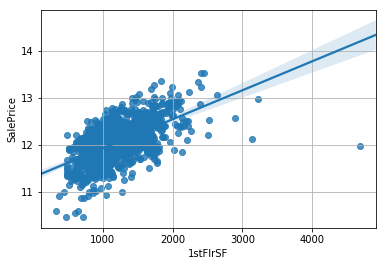

0.8499463091778436

In [9]:
# 顯示 1stFlrSF 與目標值的散佈圖
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

_df = copy.copy(df)
sns.regplot(x = _df['1stFlrSF'][:train_num], y=train_Y)
plt.grid()
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(_df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8886877546783781


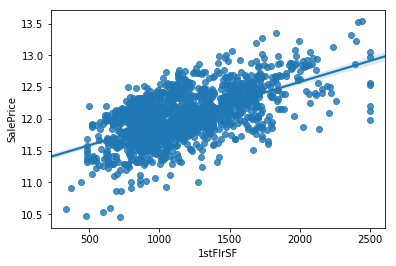

In [10]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
# 怎麼調整？ df.clip()的說明是：Assigns values outside boundary to boundary values
# 也就是說，所謂的「調整離群值」，就是把超過邊界（小於下限及大於上限）者，其值設為邊界值
_df = copy.copy(df)
_df['1stFlrSF'] = _df['1stFlrSF'].clip(lower=250, upper=2500)
sns.regplot(x = _df['1stFlrSF'][:train_num], y=train_Y)

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(_df)
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。
* 答：<font color="red">和「調整離群值」相比，結果變差一點點（0.8887 -> 0.8882），幾乎可說是相等。造成這個細微差別的原因，應該和我們丟棄了部份資料有關</font>

0.888167251467699

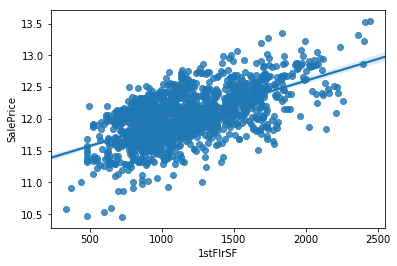

In [11]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值
# 捨棄離群值的方式： 只保留'1stFlrSF'欄位值在上、下限之間的所有列
_df = copy.copy(df)
_indexes = (_df['1stFlrSF'] >= 250) & (_df['1stFlrSF'] <= 2500)
_df = _df.loc[_indexes , :]
train_Y_new = train_Y.loc[_indexes]
sns.regplot(x = _df['1stFlrSF'][:train_Y_new.shape[0]], y=train_Y_new)

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(_df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y_new, cv=5).mean()

### 答案寫在問題下方的紅字區